pymupdf4llmを用いたpdfのjsonlへの変換

In [4]:
import os
# 定数
CHUNK_SIZE = 2000  # 1つのチャンクの最大文字数
# グローバル変数
zenkakuNum2hankakuNum = str.maketrans("０１２３４５６７８９", "0123456789")
zenkakuAlpha2hankakuAlpha = str.maketrans("ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ", "ABCDEFGHIJKLMNOPQRSTUVWXYZ")
zenkakuAlpha2hankakuAlpha_lowercase = str.maketrans("ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ", "abcdefghijklmnopqrstuvwxyz")
# 入出力パス
input_file_path = os.path.join("input", "道路法.pdf")
output_file_path = os.path.join("output", "道路法.jsonl")

# フォルダ準備
os.makedirs("input", exist_ok=True)
os.makedirs("output", exist_ok=True)

In [5]:
import re
import json
import pymupdf4llm


# PDFからテキストを抽出する関数
def extract_text_from_pdf(pdf_file):
    text = pymupdf4llm.to_markdown(pdf_file)
    return text

def pre_clean_text(text: str) -> str:

    # pymupdf4llmを使う場合
    pattern1 = r"-+\n+"     # ページ区切りのハイフンを削除
    pattern2 = r"##\s*\d+"  # ページ番号を削除
    combined_pattern = f"{pattern1}|{pattern2}"
    text = re.sub(combined_pattern, "", text, flags=re.DOTALL)

    text = text.replace("\n", "")
    text = text.translate(zenkakuNum2hankakuNum)  # 全角数字 -> 半角数字に変換
    text = text.translate(zenkakuAlpha2hankakuAlpha)  # 全角アルファベット -> 半角
    text = text.translate(zenkakuAlpha2hankakuAlpha_lowercase)  # 全角小文字アルファベット -> 半角小文字アルファベット
    text = text.replace("　", " ")  # 全角スペース-> 半角スペースに変換
    text = text.replace(" ）", "）")  # 余分なスペースの削除（注意：全角の）である。よく見るとかなりある）後の正規表現で影響するので削除
    text = text.replace("。。", "。")  # 連続する「。」の削除（よく見ると、たまにある）
    text = text.replace("、、", "、")  # 連続する「、」の削除（念のため）

    return text

def remove_short_chunks(chunks, min_length=100):
    '''短すぎるチャンクを削除する関数
    '''
    refined_chunks = []
    for chunk in chunks:
        if len(chunk) >= min_length:
            refined_chunks.append(chunk)
    return refined_chunks

# sectionごとにテキストを分割する関数
def split_text_into_chapters_with_content(text, title_pattern=r"(第[一二三四五六七八九十百千]+編 \s*.*?)(?=第[一二三四五六七八九十百千]+編 |$)"):
    # 正規表現パターンのコンパイル
    pattern = re.compile(title_pattern, re.DOTALL)
    matches = re.finditer(pattern, text) 
    chapters = []
    prev_start = None
    prev_match = None

    # 章タイトルの位置を利用して、各章の内容を抽出
    for match in matches:
        if prev_start is not None:
            # 前回の章タイトルから次の章タイトルまでを抽出
            chapter_content = text[prev_start:match.start()].strip()
            chapters.append(prev_match.group() + " " + chapter_content)  # 章タイトル + 半角空白 + 章の内容
        prev_start = match.start()
        prev_match = match

    # 最後の章の内容を取得
    if prev_match:
        chapter_content = text[prev_start:].strip()
        chapters.append(prev_match.group() + " " + chapter_content)

    # 「第〇編」が見つからなかった場合、元のテキスト全体をリストとして返す
    if not chapters:
        return [text]  # テキスト全体をリスト形式にして返す

    return chapters


def split_large_chunks(chunk, max_length=2000):
    '''
    チャンクが2000文字以上の場合に、「章」-> 「節」 -> 「条」で分割する関数
    '''
    if len(chunk) <= max_length:
        return [chunk]
    
    # 「章」で分割
    split_chunks = split_text_into_chapters_with_content(chunk, title_pattern=r"(第[一二三四五六七八九十百千]+章 \s*.*?)(?=第[一二三四五六七八九十百千]+章 |$)")

    adjusted_chunks = []
    for split_chunk in split_chunks:
        if len(split_chunk) <= max_length:
            adjusted_chunks.append(split_chunk)
        else:
            # 節で分割
            split_chunks2 = split_text_into_chapters_with_content(split_chunk, title_pattern=r"(第[一二三四五六七八九十百千]+節 \s*.*?)(?=第[一二三四五六七八九十百千]+節 |$)")
            for split_chunk2 in split_chunks2:
                adjusted_chunks.append(split_chunk2)

    # 「節」で分割しても2000文字以上の場合は、さらに「条」で分割
    re_adjusted_chunks = []
    for ac in adjusted_chunks:
        if len(ac) <= max_length:
            re_adjusted_chunks.append(ac)
        else:
            split_chunks3 = split_text_into_chapters_with_content(ac, title_pattern=r"(第[一二三四五六七八九十百千]+条 \s*.*?)(?=第[一二三四五六七八九十百千]+条 |$)")
            for split_chunk3 in split_chunks3:
                re_adjusted_chunks.append(split_chunk3)

    return re_adjusted_chunks

# 各章をJSONL形式に変換して保存する関数
def save_chapters_to_jsonl(chapters, output_file):
    with open(output_file, 'w', encoding='utf-8') as jsonl_file:
        for chapter in chapters:
            chapter_data = {"text": chapter}
            jsonl_file.write(json.dumps(chapter_data, ensure_ascii=False) + "\n")

# メイン処理
def process_pdf_to_jsonl(pdf_file, output_file):
    # PDFからテキストを抽出
    text = extract_text_from_pdf(pdf_file)
    
    # テキストの前処理
    text = pre_clean_text(text)

    # 章番号と内容を含めてテキストを分割
    chapters = split_text_into_chapters_with_content(text)
    
    # チャンクが短すぎる場合は削除
    chapters = remove_short_chunks(chapters, min_length=100)

    # # チャンクが大きすぎる場合は分割
    refined_chapters = []
    for chapter in chapters:
        refined_chapters.extend(split_large_chunks(chapter, max_length=CHUNK_SIZE))

    # 章ごとのデータをJSONL形式で保存
    save_chapters_to_jsonl(refined_chapters, output_file)
    print(f"JSONL形式で保存しました: {output_file}")



In [23]:
import re
import json
import pymupdf4llm

# PDFからテキストを抽出する関数
def extract_text_from_pdf(pdf_file):
    text = pymupdf4llm.to_markdown(pdf_file)
    return text

def pre_clean_text(text: str) -> str:

    # pymupdf4llmを使う場合
    pattern1 = r"-+\n+"     # ページ区切りのハイフンを削除
    pattern2 = r"##\s*\d+"  # ページ番号を削除
    combined_pattern = f"{pattern1}|{pattern2}"
    text = re.sub(combined_pattern, "", text, flags=re.DOTALL)

    text = text.replace("\n", "")
    text = text.translate(zenkakuNum2hankakuNum)  # 全角数字 -> 半角数字に変換
    text = text.translate(zenkakuAlpha2hankakuAlpha)  # 全角アルファベット -> 半角
    text = text.translate(zenkakuAlpha2hankakuAlpha_lowercase)  # 全角小文字アルファベット -> 半角小文字アルファベット
    text = text.replace("）", ")").replace("（", "(")  # 全角カッコ -> 半角カッコに変換
    text = text.replace("　", " ")  # 全角スペース-> 半角スペースに変換
    text = text.replace(" ）", "）")  # 余分なスペースの削除（注意：全角の）である。よく見るとかなりある）後の正規表現で影響するので削除
    text = text.replace("。。", "。")  # 連続する「。」の削除（よく見ると、たまにある）
    text = text.replace("、、", "、")  # 連続する「、」の削除（念のため）

    return text

# 短いチャンクを削除する関数
def remove_short_chunks(chunks, min_length=100):
    '''短すぎるチャンクを削除する関数'''
    return [chunk for chunk in chunks if len(chunk) >= min_length]

# テキストを指定されたパターンで分割する関数
def split_text_into_chapters_with_content(text, title_pattern=r"(第[一二三四五六七八九十百千]+編 \s*.*?)(?=第[一二三四五六七八九十百千]+編 |$)"):
    # 正規表現パターンのコンパイル
    pattern = re.compile(title_pattern, re.DOTALL)
    matches = list(re.finditer(pattern, text))  

    chapters = []
    prev_start = None
    prev_match = None

    # 章タイトルの位置を利用して、各章の内容を抽出
    for match in matches:
        if prev_start is not None:
            # 前回の章タイトルから次の章タイトルまでを抽出（章タイトルを含まない内容を取得）
            chapter_content = text[prev_start:match.start()].strip()

            # 章タイトル部分を chapter_content から削除し、重複を防ぐ
            if chapter_content.startswith(prev_match.group()):
                chapter_content = chapter_content[len(prev_match.group()):].strip()
            
            # 章タイトル（prev_match.group()）と章内容（chapter_content）を結合
            combined_content = f"{prev_match.group().strip()} {chapter_content}"
            chapters.append(combined_content)  # 章タイトルと内容を結合した形で追加
        prev_start = match.start()
        prev_match = match

    # 最後の章の内容を取得
    if prev_match:
        # 最後の章タイトル以降のすべての内容を取得
        chapter_content = text[prev_start:].strip()
        
        # 章タイトル部分を chapter_content から削除し、重複を防ぐ
        if chapter_content.startswith(prev_match.group()):
            chapter_content = chapter_content[len(prev_match.group()):].strip()

        combined_content = f"{prev_match.group().strip()} {chapter_content}"
        chapters.append(combined_content)

    # 「第〇編」が見つからなかった場合、元のテキスト全体をリストとして返す
    if not chapters:
        return [text]  # テキスト全体をリスト形式にして返す


    return chapters

def split_text_by_length(text, max_length):
    # 初期分割を「。」で行う。ただし「。」の次に「)」が続く場合は分割しない
    pattern = r'。(?=[^)]*(?:\([^)]*\)|$))'
    initial_sentences = re.split(pattern, text)

    # 分割後の文末に「。」を追加
    initial_sentences = [sentence + "。" for sentence in initial_sentences if sentence]

    # 各文を指定した最大文字数以下に調整
    final_sentences = []
    buffer_sentence = ""  # 現在のバッファ文を保持する変数

    for sentence in initial_sentences:
        if len(buffer_sentence) + len(sentence) <= max_length:
            # 現在のバッファに追加してもmax_lengthを超えない場合
            buffer_sentence += sentence
        else:
            # 追加するとmax_lengthを超える場合、現在のバッファを結果に追加し、バッファをクリア
            if buffer_sentence:
                final_sentences.append(buffer_sentence.strip())
            buffer_sentence = sentence  # 新しい文をバッファに設定

    # 最後に残ったバッファ文を追加
    if buffer_sentence:
        final_sentences.append(buffer_sentence.strip())

    return final_sentences

# 最終手段
def split_large_chunks_by_period(chunk, max_length=2000):
    # チャンクが2000文字を超えない場合は、そのまま返す
    if len(chunk) <= max_length:
        return [chunk]
    
    # 句読点「。」で文を分割する
    sentences = chunk.split("。")
    current_chunk = ""  # 現在のチャンクを保持
    split_chunks = []  # 分割されたチャンクを保持

    for sentence in sentences:
        # 文末の句読点「。」を元に戻す（splitで取り除かれるため）
        sentence = sentence + "。"
        
        # 現在のチャンクに追加しても2000文字を超えない場合は、現在のチャンクに追加
        if len(current_chunk) + len(sentence) <= max_length:
            current_chunk += sentence
        else:
            # 現在のチャンクが2000文字を超える場合は、新しいチャンクとして保存し、新たに開始
            split_chunks.append(current_chunk)
            current_chunk = sentence
    
    # 最後に残ったチャンクを保存
    if current_chunk:
        split_chunks.append(current_chunk)
    
    return split_chunks
# 大きすぎるチャンクを再分割する関数
def split_large_chunks(chunk, max_length=2000):
    if len(chunk) <= max_length:
        return [chunk]  # リスト形式で返す

    # 章で分割
    split_chunks = split_text_into_chapters_with_content(chunk, title_pattern=r"(第[一二三四五六七八九十百千]+章 \s*.*?)(?=第[一二三四五六七八九十百千]+章 |$)")
    
    # 章で分割しても大きい場合は、さらに節で分割
    adjusted_chunks = []
    for split_chunk in split_chunks:
        if len(split_chunk) <= max_length:
            adjusted_chunks.append(split_chunk)
        else:
            split_chunks2 = split_text_into_chapters_with_content(split_chunk, title_pattern=r"(第[一二三四五六七八九十百千]+節 \s*.*?)(?=第[一二三四五六七八九十百千]+節 |$)")
            adjusted_chunks.extend(split_chunks2)

    # 節で分割しても2000文字を超える場合は、条で分割
    re_adjusted_chunks = []
    for ac in adjusted_chunks:
        if len(ac) <= max_length:
            re_adjusted_chunks.append(ac)
        else:
            split_chunks3 = split_text_into_chapters_with_content(ac, title_pattern=r"(第[一二三四五六七八九十百千]+条(?:の[一二三四五六七八九十百千]+)?) *.*?(?=第[一二三四五六七八九十百千]+条(?:の[一二三四五六七八九十百千]+)? |$)")
            re_adjusted_chunks.extend(split_chunks3)

    # それでも2000文字を超える場合は、句読点「。」で分割
    final_chunks = []
    for rac in re_adjusted_chunks:
        if len(rac) <= max_length:
            final_chunks.append(rac)
        else:
            split_chunks4 = split_text_by_length(rac, max_length)
            final_chunks.extend(split_chunks4)

    # 最終手段として、2000文字を超える場合は、句読点「。」再分割（ここは最悪、人手でやる）
    re_final_chunks = []
    for fc in final_chunks:
        if len(fc) <= max_length:
            re_final_chunks.append(fc)
        else:
            split_chunks5 = split_large_chunks_by_period(fc, max_length)
            re_final_chunks.extend(split_chunks5)

    return re_final_chunks


# 各章をJSONL形式に変換して保存する関数
def save_chapters_to_jsonl(chapters, output_file):
    with open(output_file, 'w', encoding='utf-8') as jsonl_file:
        for chapter in chapters:
            chapter_data = {"text": chapter}
            jsonl_file.write(json.dumps(chapter_data, ensure_ascii=False) + "\n")

# メイン処理
def process_pdf_to_jsonl(pdf_file, output_file, chunk_size=2000):
    # PDFからテキストを抽出
    text = extract_text_from_pdf(pdf_file)
    
    # テキストの前処理
    text = pre_clean_text(text)

    # 章番号と内容を含めてテキストを分割
    chapters = split_text_into_chapters_with_content(text)
    

    # チャンクが大きすぎる場合は分割
    refined_chapters = []
    for chapter in chapters:
        refined_chapters.extend(split_large_chunks(chapter, max_length=chunk_size))

    # チャンクが短すぎる場合は削除
    # refined_chapters = remove_short_chunks(refined_chapters, min_length=100)

    # 章ごとのデータをJSONL形式で保存
    save_chapters_to_jsonl(refined_chapters, output_file)
    print(f"JSONL形式で保存しました: {output_file}")



In [24]:
# PDF -> JSONL形式に変換
process_pdf_to_jsonl(input_file_path, output_file_path)

Processing input\道路法.pdf...
[                                        ] (0/44[                                        ] ( 1/44[=                                       ] ( 2/4[==                                      ] ( 3/44[===                                     ] ( 4/4[====                                    ] ( 5/44[=====                                   ] ( 6/4[======                                  ] ( 7/44[=======                                 ] ( 8/4[========                                ] ( 9/44[=========                               ] (10/4[==========                              ] (11/4[==========                              ] (12/44[===========                             ] (13/4[============                            ] (14/44[=============                           ] (15/4[==============                          ] (16/44[===============                         ] (17/4[================                        ] (18/44[=================                       ] (19/4[==

チャンクサイズの分布を確認

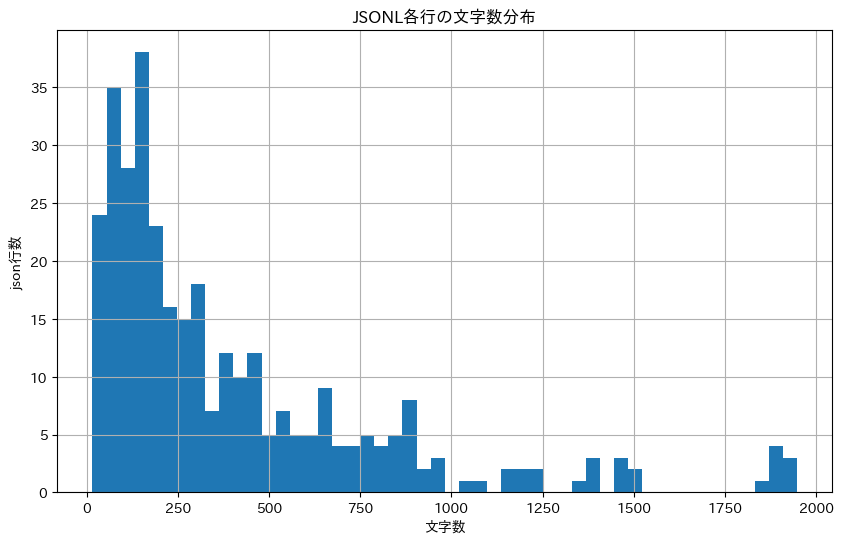

2000文字以上の行番号と文字数
[]


In [25]:
import json
import matplotlib.pyplot as plt
import japanize_matplotlib

def read_jsonl_file(file_path):
    lines = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line.strip()) 
            lines.append(json_obj['text'])  
    return lines

def check_line_length(lines, max_length=2000):
    long_lines = [] 
    for i, line in enumerate(lines):
        if len(line) >= max_length:
            long_lines.append((i+1, len(line)))
    return long_lines

def visualize_line_lengths(lines):
    # 各行の文字数を計算
    line_lengths = [len(line) for line in lines]

    plt.figure(figsize=(10, 6))
    plt.hist(line_lengths, bins=50)
    plt.title('JSONL各行の文字数分布')
    plt.xlabel('文字数')
    plt.ylabel('json行数')
    plt.grid(True)
    plt.show()

jsonl_file_path = "output\\道路法.jsonl"  
lines = read_jsonl_file(jsonl_file_path)

# 各行の文字数を可視化
visualize_line_lengths(lines)
print("2000文字以上の行番号と文字数")
print(check_line_length(lines))
